In [13]:
import pandas as pd
import shutil
import os

In [14]:
file_path = "./HAM10000_metadata.csv"
data_type = {0:'nv', 1:'mel', 2:'bcc'}
img_dir = './dataset/img'
pre_dir = './ham10000_images'
# img_dir1 = './ham10000_images_part_1'
# img_dir2 = './ham10000_images_part_1'

In [3]:
df = pd.read_csv(file_path)

In [4]:
print(len(df1_bcc))
print(len(df1_mel))
print(len(df1_nv))

NameError: name 'df1_bcc' is not defined

In [5]:
df[:1]

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp


In [6]:
def moveimg(data_type:dict, img_dir:str, pre_dir:str):
    for num in range(3):
        df_type = df[df['dx'] == data_type[num]]
        filename_type = df_type['image_id'].values
        for i in range(len(filename_type)):
            image_id_type = filename_type[i]
            shutil.copy2(f'{pre_dir}/{image_id_type}.jpg', f'{img_dir}/{data_type[num]}/{data_type[num]}{i}.jpg')

In [7]:
moveimg(data_type, img_dir, pre_dir)

In [8]:
df_bcc = df[df['dx'] == 'bcc']

## preprocess

#### resize

In [15]:
import cv2
import numpy as np

In [5]:
def resizeimg(img_file:str):
    img = cv2.imread(img_file)
    height = img.shape[0]
    width  = img.shape[1]
    img2 = cv2.resize(img, (int(width*0.5), int(height*0.50)))
    return img2

def save_img(data_type:dict, img_dir:str):
    for num in range(3):
        for i in range(len(df[df['dx'] == data_type[num]])):
            img_file = f'{img_dir}/{data_type[num]}/{data_type[num]}{i}.jpg'
            new_img = resizeimg(img_file)
            cv2.imwrite(f"{img_dir}/half_size/{data_type[num]}/{data_type[num]}{i}.jpg", new_img)
        
def addarray(arr1:list, arr2:list):
    if arr1.ndim == 3:
        zeroarray = np.zeros((2, arr2.shape[0], arr2.shape[1], 3))
        zeroarray[0] += arr1
        zeroarray[1] += arr2
    else:
        zeroarray= np.zeros((arr1.shape[0]+1, arr2.shape[0], arr2.shape[1], 3))
        for i in range(arr1.shape[0]):
            zeroarray[i] += arr1[i]
        zeroarray[zeroarray.shape[0]-1] += arr2
    return zeroarray

In [6]:
save_img(data_type, img_dir)

#### augumentation

In [9]:
import sys
import re
import glob

In [11]:
# ヒストグラム均一化
def equalizeHistRGB(src):

    RGB = cv2.split(src)
    Blue   = RGB[0]
    Green = RGB[1]
    Red    = RGB[2]
    for i in range(3):
        cv2.equalizeHist(RGB[i])

    img_hist = cv2.merge([RGB[0],RGB[1], RGB[2]])
    return img_hist

# ガウシアンノイズ
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss

    return noisy

# salt&pepperノイズ
def addSaltPepperNoise(src):
    row,col,ch = src.shape
    s_vs_p = 0.5
    amount = 0.004
    out = src.copy()
    # Salt mode
    num_salt = np.ceil(amount * src.size * s_vs_p)
    coords = [np.random.randint(0, i-1 , int(num_salt))
                 for i in src.shape]
    out[coords[:-1]] = (255,255,255)

    # Pepper mode
    num_pepper = np.ceil(amount* src.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i-1 , int(num_pepper))
             for i in src.shape]
    out[coords[:-1]] = (0,0,0)
    return out

def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_path(data_type:str, img_dir:str):
    path = f"{img_dir}/resize_img/{data_type}/{data_type}*"
    flist = sorted(glob.glob(path), key=numericalSort)
    return flist

In [8]:
if __name__ == '__main__':
    # ルックアップテーブルの生成
    min_table = 50
    max_table = 205
    diff_table = max_table - min_table
    gamma1 = 0.75
    gamma2 = 1.5

    LUT_HC = np.arange(256, dtype = 'uint8' )
    LUT_LC = np.arange(256, dtype = 'uint8' )
    LUT_G1 = np.arange(256, dtype = 'uint8' )
    LUT_G2 = np.arange(256, dtype = 'uint8' )

    LUTs = []

    # 平滑化用
    average_square = (2, 2)

    # ハイコントラストLUT作成
    for i in range(0, min_table):
        LUT_HC[i] = 0

    for i in range(min_table, max_table):
        LUT_HC[i] = 255 * (i - min_table) / diff_table

    for i in range(max_table, 255):
        LUT_HC[i] = 255

    # その他LUT作成
    for i in range(256):
        LUT_LC[i] = min_table + i * (diff_table) / 255
        LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1) 
        LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)

    LUTs.append(LUT_HC)
    LUTs.append(LUT_LC)
    LUTs.append(LUT_G1)
    LUTs.append(LUT_G2)

In [9]:
def augumentation(data_type:dict, img_dir:str):
    for num in range(3):
        j = 1
        flist = get_path(data_type[num], img_dir)

        for file in flist:
            # 画像の読み込み
            img_src = cv2.imread(file)
            trans_img = []
            trans_img.append(img_src)

            # LUT変換
            for i, LUT in enumerate(LUTs):
                trans_img.append(cv2.LUT(img_src, LUT))

            # 平滑化      
            trans_img.append(cv2.blur(img_src, average_square))      

            # ヒストグラム均一化
            trans_img.append(equalizeHistRGB(img_src))

            # ノイズ付加
            trans_img.append(addGaussianNoise(img_src))
            trans_img.append(addSaltPepperNoise(img_src))

            # 反転
            flip_img = []
            for img in trans_img:
                flip_img.append(cv2.flip(img, 1))
            trans_img.extend(flip_img)

    #         base = f"{member}/{member}"+str(j)+"_"
            base = f'{img_dir}/aug_img/{data_type[num]}/{data_type[num]}{j}_'
            j += 1
            img_src.astype(np.float64)
            for i, img in enumerate(trans_img):
                cv2.imwrite(f'{base}{i}.jpg' ,img) 

In [10]:
augumentation(data_type, img_dir)

#### datasets

In [16]:
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image

Using TensorFlow backend.


In [25]:
def get_aug_path(data_type:str, img_dir:str):
    path = f"{img_dir}/resize_img/{data_type}/{data_type}*"
    flist = sorted(glob.glob(path), key=numericalSort)
    return flist

def img_array(data_type:str, img_dir:str, data_num:int):
    img_array = np.zeros((data_num, 75, 100))
    img_path = get_aug_path(data_type, img_dir)
    for i in range(data_num):
        img_array[i] += np.array((Image.open(img_path[i])).convert('L'))
    img_train, img_test = train_test_split(img_array, train_size= 0.8)
    return img_train, img_test

In [26]:
nv_train, nv_test = img_array(data_type[0], img_dir, 514)
mel_train, mel_test = img_array(data_type[1], img_dir, 514)
bcc_train, bcc_test = img_array(data_type[2], img_dir, 514)
# bcc_train, bcc_test = img_array(data_type[2], img_dir, 9252)

/home/deepstation/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [27]:
514*0.8

411.20000000000005

In [35]:
def dataset(dataset:int, data1:list, data2:list, data3:list):
#     datasets = {0:7401, 1:1851}
    datasets = {0:411, 1:103}
    data = {0:data1, 1:data2, 2:data3}
    x = np.zeros((datasets[dataset]*3, 75, 100))
    for num in range(3):
        data_num = data[num]
        for i in range(datasets[dataset]):
            x[(num*datasets[dataset])+i] += data_num[i]
    return x

In [70]:
x_train = dataset(0, nv_train, mel_train, bcc_train)
x_test = dataset(1, nv_test, mel_test, bcc_test)
x_train = x_train.reshape((x_train.shape[0], 75, 100, 1))
x_test = x_test.reshape((x_test.shape[0], 75, 100, 1))

In [71]:
y_train = np.repeat([0, 1, 2], nv_train.shape[0])
y_test = np.repeat([0, 1, 2], nv_test.shape[0])
# y_train = to_categorical(_y_train)
# y_test = to_categorical(_y_test) 

In [72]:
x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)
x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [73]:
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [74]:
print(f'''
Dataset shape
x_train: {x_train.shape} |-> y_train: {y_train.shape},
x_test: {x_test.shape} |-> y_test: {y_test.shape},
x_validate: {x_validate.shape} |-> y_validate: {y_validate.shape}''')


Dataset shape
x_train: (1109, 75, 100, 1) |-> y_train: (1109, 3),
x_test: (309, 75, 100, 1) |-> y_test: (309, 3),
x_validate: (124, 75, 100, 1) |-> y_validate: (124, 3)


## ResNet

In [76]:
from keras.utils import plot_model
from keras.optimizers import SGD
from keras.models import Model
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from ResNet_build import ResnetBuilder
from keras import losses
from utility import utility
from PIL import Image
import random
import numpy as np
import pickle
import os
from keras.layers import Input, Conv2D, AveragePooling2D, BatchNormalization, Add, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

class TestModel:
    def __init__(self, use_resblock, nb_blocks):
        self.use_resblock = use_resblock
        self.nb_blocks = nb_blocks
        # モデルの作成
        self.model = self._create_model()
        # モデル名
        self.name = ""
        if use_resblock: self.name += "use_res_"
        else: self.name += "no_res_"
        self.name = f"{self.name}{self.nb_blocks:02d}"

    def _create_model(self):
        input = Input(shape=(75, 100, 1))
        X = input
        n_filter = 64
        for i in range(self.nb_blocks):
            # 3ブロック単位でAveragePoolingを入れる、フィルター数を倍にする
            if i % 3 == 0 and i != 0:
                X = AveragePooling2D((2,2))(X)
                n_filter *= 2
            # ショートカットとメインのフィルター数を揃えるために活性化関数なしの畳込みレイヤーを作る
            if i % 3 == 0:
                X = Conv2D(n_filter, (4,4), padding="same")(X)
            # 1ブロック単位の処理
            if self.use_resblock:
                # ショートカット：ショートカット→BatchNorm（ResBlockを使う場合のみ）
                shortcut = X
                shortcut = BatchNormalization()(shortcut)
            # メイン
            # 畳み込み→BatchNorm→活性化関数
            X = Conv2D(n_filter, (4,4), padding="same")(X)
#             X = BatchNormalization()(X)
            X = Activation("relu")(X)
            X = Dropout(0.2)(X)
            # 畳み込み→BatchNorm
#             X = Conv2D(n_filter, (4,4), padding="same")(X)
#             X = BatchNormalization()(X)
            if self.use_resblock:
                # ショートカットとマージ（ResBlockを使う場合のみ）
                X = Add()([X, shortcut])
            # 活性化関数
            X = Activation("relu")(X)
        # 全結合
        X = Flatten()(X)
        y = Dense(3, activation="softmax")(X)
        X = Dropout(0.5)(X)
        # モデル
        model = Model(inputs=input, outputs=y)
        return model

    def train(self, Xtrain, ytrain, Xval, yval, nb_epoch=70, learning_rate=0.01):
        self.model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
        history = self.model.fit(Xtrain, ytrain, batch_size=512, epochs=nb_epoch, validation_data=(Xval, yval)).history
        # historyの保存
        if not os.path.exists("history"): os.mkdir("history")
        self.model.save(f"./history/{self.name}.h5")
        with open(f"history/{self.name}.dat", "wb") as fp:
            pickle.dump(history, fp)

if __name__ == "__main__":
    # データの読み込み
    (X_train, y_train), (X_test, y_test) = (x_train, y_train), (x_test, y_test)
#     X_train, X_test = X_train / 255.0, X_test / 255.0
#     y_train, y_test = to_categorical(y_train), to_categorical(y_test)
    # テストパターン
#     resflag = [False, True]
    resflag = [True]
    nb_blocks = [3, 6, 9, 12]
    # モデルの作成
    for res in resflag:
        for nb in nb_blocks:
            print("Testing model... / ", res, nb)
            model = TestModel(res, nb)
            model.train(X_train, y_train, X_test, y_test, nb_epoch=70)

Testing model... /  True 3
Train on 1109 samples, validate on 309 samples
Epoch 1/70


ResourceExhaustedError: OOM when allocating tensor with shape[512,64,75,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_38/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training_2/Adam/gradients/conv2d_38/convolution_grad/Conv2DBackpropInput"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_45/Relu, conv2d_38/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_6/mul/_931}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1745_loss_6/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.cm import get_cmap

# データ読み込み
no_res, use_res = [], []
for i in range(4):
    with open(f"history/no_res_{i*3+3:02d}.dat", "rb") as fp:
        no_res.append(pickle.load(fp))
    with open(f"history/use_res_{i*3+3:02d}.dat", "rb") as fp:
        use_res.append(pickle.load(fp))

xlabels = np.arange(50) + 1
cmap = get_cmap("Set1")


plt.subplot(2, 1, 1)
for i in range(len(no_res)):
    plt.plot(xlabels, no_res[i]["val_acc"], color=cmap(i), label="No_res # blocks="+str(i*3+3))
plt.legend()
plt.ylim((0, 1.0))

plt.subplot(2, 1, 2)
for i in range(len(no_res)):
    plt.plot(xlabels, use_res[i]["val_acc"],  color=cmap(i), label="Use_res # blocks="+str(i*3+3))
# plt.legend()
plt.ylim((0, 1.0))

plt.suptitle("Validation accuracy")
plt.show()

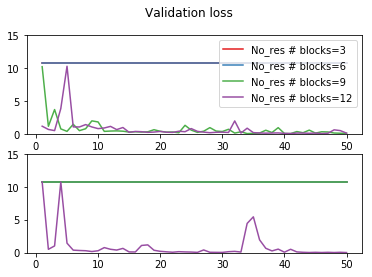

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.cm import get_cmap

# データ読み込み
no_res, use_res = [], []
for i in range(4):
    with open(f"history/no_res_{i*3+3:02d}.dat", "rb") as fp:
        no_res.append(pickle.load(fp))
    with open(f"history/use_res_{i*3+3:02d}.dat", "rb") as fp:
        use_res.append(pickle.load(fp))

xlabels = np.arange(50) + 1
cmap = get_cmap("Set1")


plt.subplot(2, 1, 1)
for i in range(len(no_res)):
    plt.plot(xlabels, no_res[i]["val_loss"], color=cmap(i), label="No_res # blocks="+str(i*3+3))
plt.legend()
plt.ylim((0, 15.0))

plt.subplot(2, 1, 2)
for i in range(len(no_res)):
    plt.plot(xlabels, use_res[i]["val_loss"],  color=cmap(i), label="Use_res # blocks="+str(i*3+3))
# plt.legend()
plt.ylim((0, 15.0))



plt.suptitle("Validation loss")
plt.show()